# Generate Data

Generate restricted IOD data based on the following parameters:

- $a$: Semi-major axis
- $e$: Eccentricity
- $\omega$: Argument of Periapsis
- $M$: Mean Anomaly *(Although in this instance, because of super low eccentricity, it could also be true anomaly)*

In [1]:
%reload_ext autoreload
%autoreload 2

from experiment.constants import INITIAL_ORBIT_PARAMS
from data.generator import generate_initial_orbit_dataset_restricted

number_of_samples = 10000
iod_dataset = generate_initial_orbit_dataset_restricted(INITIAL_ORBIT_PARAMS, number_of_samples)


# Define ELM Model and Data

Input: $n$ size scalar array

Optimizer: ADAM optimizer

Loss: Mean Squared Loss

In [2]:
from ml.model import ELM_IOD
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Defining ELM Parameters - From Paper
input_dimensions = 1
output_dimensions = 3
hidden_dimension = 18500
activation_function = 'relu'

# Model Initialization - ELM Model
iod_elm = ELM_IOD(input_size=input_dimensions,
                   hidden_layer_size=hidden_dimension,
                   output_size=output_dimensions,
                   activation=activation_function)

# Define Loss Function
criterion = nn.MSELoss()

# Define output layer optimizer
optimizer = optim.Adam(iod_elm.output.parameters(), lr=0.01)

# Define Dataset Batch
batch_size = 64
train_size = int(0.8 * len(iod_dataset))
test_size = len(iod_dataset) - train_size

# Splitting Train and Testing Dataset
train_dataset, test_dataset = random_split(iod_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Training Loop

In [3]:
import copy
import torch

epochs = 1000

best_val_loss = float('inf')
best_model_state = copy.deepcopy(iod_elm.state_dict())
for epoch in range(1, epochs + 1):
    iod_elm.train()
    epoch_loss = 0.0
    for batch_features, batch_labels in train_dataloader:
        # Forward Pass
        out = iod_elm(batch_features)
        loss = criterion(out, batch_labels)

        # Backward pass and optimization (note we dont calculate gradients for weights and biases)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_features.size(0)
    
    avg_loss = epoch_loss / train_size
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        best_model_state = copy.deepcopy(iod_elm.state_dict())
        torch.save(best_model_state, 'best_elm_state.pth')

    if epoch % 50 == 0 or epoch == 1:
        print(f'Epoch [{epoch}/{epochs}], Training Loss: {avg_loss:.4f}')

Epoch [1/1000], Training Loss: 1660769222.6560
Epoch [50/1000], Training Loss: 476976544.0000
Epoch [100/1000], Training Loss: 51914091.9360
Epoch [150/1000], Training Loss: 132729.5862
Epoch [200/1000], Training Loss: 251952.0158
Epoch [250/1000], Training Loss: 244408.6374
Epoch [300/1000], Training Loss: 180364.4895
Epoch [350/1000], Training Loss: 162245.9161
Epoch [400/1000], Training Loss: 355327.6830
Epoch [450/1000], Training Loss: 140708.7448
Epoch [500/1000], Training Loss: 58154.9292
Epoch [550/1000], Training Loss: 65445.9748
Epoch [600/1000], Training Loss: 112554.3238
Epoch [650/1000], Training Loss: 58961.3015
Epoch [700/1000], Training Loss: 141225.6588
Epoch [750/1000], Training Loss: 211067.6297
Epoch [800/1000], Training Loss: 40157.0603
Epoch [850/1000], Training Loss: 55267.9289
Epoch [900/1000], Training Loss: 40045.4809
Epoch [950/1000], Training Loss: 101827.3895
Epoch [1000/1000], Training Loss: 50263.3183


# Evaluation and Plotting

In [4]:
# Instantiate Best Model State
evaluation_model = iod_elm = ELM_IOD(input_size=input_dimensions,
                   hidden_layer_size=hidden_dimension,
                   output_size=output_dimensions,
                   activation=activation_function)

evaluation_state = torch.load('best_elm_state.pth')
evaluation_model.load_state_dict(evaluation_state)

# Initialize lists to store predictions and labels
all_predictions = []
all_labels = []

evaluation_model.eval()
# Disable gradient calculations
with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
        # Forward pass: compute predictions
        predictions = evaluation_model(batch_features)
        
        # Append predictions and labels to the lists
        all_predictions.append(predictions)
        all_labels.append(batch_labels)

# Concatenate all batches into single tensors
all_predictions = torch.cat(all_predictions, dim=0)  # Shape: (n_test_samples, 3)
all_labels = torch.cat(all_labels, dim=0)            # Shape: (n_test_samples, 3)

# Optionally, move tensors to CPU and convert to NumPy for plotting
all_predictions_np = all_predictions.cpu().numpy()
all_labels_np = all_labels.cpu().numpy()

print(f'All Predictions Shape: {all_predictions_np.shape}')
print(f'All Labels Shape: {all_labels_np.shape}')

All Predictions Shape: (2000, 3)
All Labels Shape: (2000, 3)


/var/folders/d7/d_zqr0nx3z784m45x700fnkm0000gp/T/ipykernel_79760/2300092669.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  evaluation_state = torch.load('best_elm_state

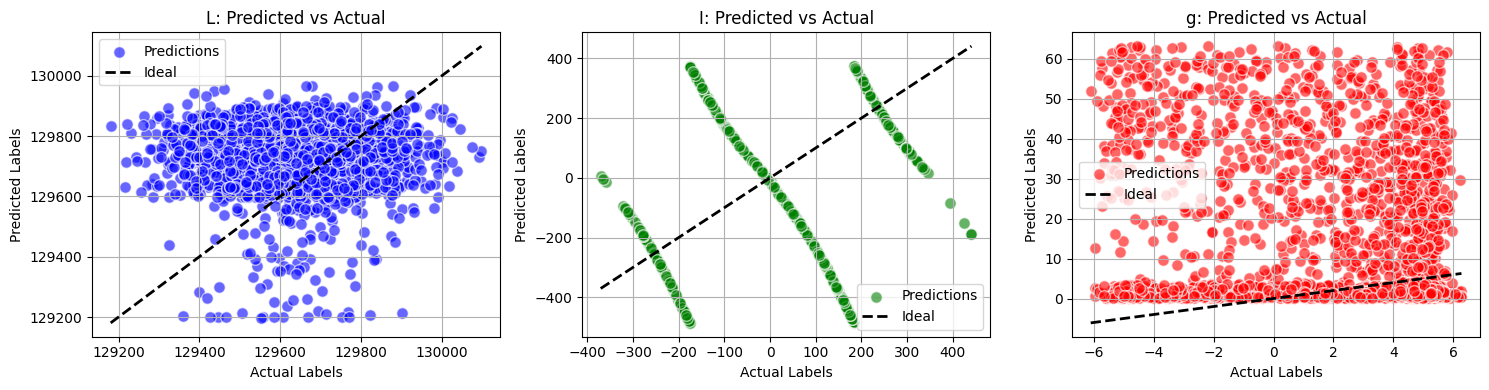

In [6]:
# Plotting
import matplotlib.pyplot as plt

colors = ['b', 'g', 'r']
output_labels = ['L', 'I', 'g']

# Create subplots for each output dimension
fig, axes = plt.subplots(1, output_dimensions, figsize=(5 * output_dimensions, 4))

if output_dimensions == 1:
    axes = [axes]

for i in range(output_dimensions):
    ax = axes[i]
    ax.scatter(all_labels_np[:, i], all_predictions_np[:, i],
               alpha=0.6, edgecolors='w', s=70, color=colors[i], label='Predictions')
    ax.plot([all_labels_np[:, i].min(), all_labels_np[:, i].max()],
            [all_labels_np[:, i].min(), all_labels_np[:, i].max()],
            'k--', lw=2, label='Ideal')
    ax.set_xlabel('Actual Labels')
    ax.set_ylabel('Predicted Labels')
    ax.set_title(f'{output_labels[i]}: Predicted vs Actual')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
